In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib

In [13]:
df = pd.read_csv("commonlitreadabilityprize/train.csv")
df = df.drop(columns=["url_legal", "license"])
print(df.shape)
df.head(10)

(2834, 4)


,id,excerpt,target,standard_error
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845
5,f9bf357fe,Hal and Chester found ample time to take an in...,-0.861809,0.480936
6,eaf8e7355,Hal Paine and Chester Crawford were typical Am...,-1.759061,0.476507
7,0a43a07f1,"On the twenty-second of February, 1916, an aut...",-0.952325,0.498116
8,f7eff7419,The boys left the capitol and made their way d...,-0.371641,0.463710
9,d96e6dbcd,One day he had gone beyond any point which he ...,-1.238432,0.465900


-3.676267773 1.711389827


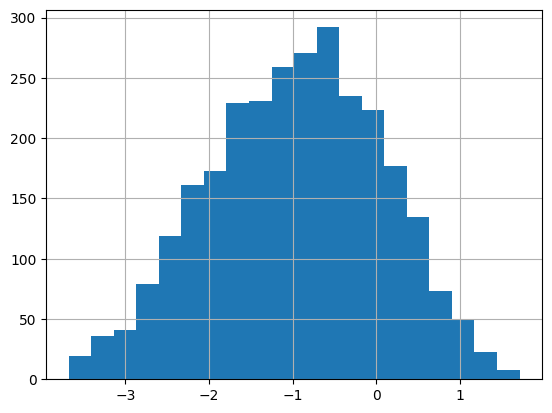

In [14]:
df["target"].hist(bins=20)
print(df["target"].min(), df["target"].max())

In [15]:
# added grade column based on excerpt
# use standard error to adjust scores with the confidence level

df['grade'] = pd.cut(df['target'], bins=[-2.35, -1.875, -1.53, -1.199, -1.192, -0.643, -0.466, -.136, .47 , .81, 1.71], labels=range(12, 2, -1))

In [16]:
from textstat import flesch_kincaid_grade
from sklearn.preprocessing import MinMaxScaler


# Create a new feature for readability score
df['flesch_kincaid'] = df['excerpt'].apply(flesch_kincaid_grade)

# Normalize the Flesch-Kincaid scores
scaler = MinMaxScaler()
df['flesch_kincaid'] = scaler.fit_transform(df[['flesch_kincaid']])

In [17]:
# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model

# Text input and vectorization layer
text_input = Input(shape=(), dtype=tf.string, name="text_input")
vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=200)
vectorizer.adapt(df['excerpt'])  # Fit vectorizer on the text data

# Apply vectorization and embedding
text_vectorized = vectorizer(text_input)
embedding = Embedding(input_dim=10000, output_dim=128)(text_vectorized)
pooled_text = GlobalAveragePooling1D()(embedding)

# Readability score input
readability_input = Input(shape=(1,), name="readability_input")

# Concatenate text and readability features
concatenated = Concatenate()([pooled_text, readability_input])

# Dense layers to learn from combined features
dense1 = Dense(128, activation="relu")(concatenated)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Output layer for regression
output = Dense(1, name="target_output")(dropout2)

# Define the model with both inputs
model = Model(inputs=[text_input, readability_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [19]:
# Split data into features and target
train_texts = train_df['excerpt']
train_targets = train_df['target']
train_readability = train_df['flesch_kincaid']

val_texts = val_df['excerpt']
val_targets = val_df['target']
val_readability = val_df['flesch_kincaid']

# Train the model with both inputs
history = model.fit(
    [train_texts, train_readability], train_targets,
    validation_data=([val_texts, val_readability], val_targets),
    epochs=10,
    batch_size=32
)

Epoch 1/10


c:\Users\yxl21\Documents\School\hacktx2024\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'readability_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2682 - mae: 0.8924 - val_loss: 0.5739 - val_mae: 0.6060
Epoch 2/10
 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6394 - mae: 0.6125

c:\Users\yxl21\Documents\School\hacktx2024\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'readability_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5752 - mae: 0.5984 - val_loss: 0.4706 - val_mae: 0.5492
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4444 - mae: 0.5186 - val_loss: 0.4345 - val_mae: 0.5229
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3507 - mae: 0.4608 - val_loss: 0.4704 - val_mae: 0.5489
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3021 - mae: 0.4287 - val_loss: 0.4423 - val_mae: 0.5284
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2182 - mae: 0.3609 - val_loss: 0.4304 - val_mae: 0.5186
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1674 - mae: 0.3108 - val_loss: 0.4813 - val_mae: 0.5488
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1599 - mae: 0.3018 - val_loss: 0.4571 - val_mae: 0.5340
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1406 - mae: 0.2856 - val_loss: 0.4868 - val_mae: 0.5519
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1194 - mae: 0.2642 - v

In [20]:
# Evaluate the model
loss, mae = model.evaluate([val_texts, val_readability], val_targets)
print(f"Validation MAE: {mae}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4351 - mae: 0.5184 
Validation MAE: 0.5390605926513672


In [ ]:
import textstat
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Load the test data
test = pd.read_csv("commonlitreadabilityprize/test copy.csv")

# Calculate Flesch-Kincaid readability score for each passage in the test set
test['flesch_kincaid'] = test['excerpt'].apply(textstat.flesch_kincaid_grade)

# Normalize the readability scores using the scaler from training
test['flesch_kincaid_normalized'] = scaler.transform(test[['flesch_kincaid']])

# Vectorize all excerpts in a batch
new_texts_vectorized = vectorizer(test['excerpt'])
new_texts_vectorized = tf.convert_to_tensor(new_texts_vectorized)

# Ensure readability scores are in shape (num_samples, 1)
readability_scores = test['flesch_kincaid_normalized'].values.reshape(-1, 1)
readability_scores = tf.convert_to_tensor(readability_scores, dtype=tf.float32)

# Make predictions with both inputs
predictions = model.predict({
    'text_input': new_texts_vectorized,
    'readability_input': readability_scores
})

# Add predictions to the DataFrame
test['predictions'] = predictions

# Display the results
print(test[['excerpt', 'flesch_kincaid', 'predictions']])


c:\Users\yxl21\Documents\School\hacktx2024\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'readability_input']. Received: the structure of inputs={'text_input': '*', 'readability_input': '*'}
  warnings.warn(


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 129, but received input with shape (7, 328)[0m

Arguments received by Functional.call():
  • inputs={'text_input': 'tf.Tensor(shape=(7, 200), dtype=int64)', 'readability_input': 'tf.Tensor(shape=(7, 1), dtype=float32)'}
  • training=False
  • mask={'text_input': 'None', 'readability_input': 'None'}